## Tugas 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Dataset/voice.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


- Buatlah model klasifikasi dengan menggunakan kNN untuk mengklasifikasikan jenis suara male dan female pada dataset voice.csv.

- Lakukan percobaan untuk mengetahui fitur-fitur yang paling optimal untuk digunakan. Fitur apa saja yang Anda gunakan untuk mendapatkan hasil terbaik?

- Berdasarkan fitur yang telah Anda pilih pada soal nomor 2, berapa nilai  yang terbaik? Lampirkan grafika analisis dan alasan Anda.

In [ ]:
# Buat model Klasifikasi menggunakan kNN
# Preprocess
# Encode
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print("\nEncoding into 'female' = 0, 'male' = 1.")

# Pisahkan Fitur (X) dan Target (y)
X = df.drop('label', axis=1)
y = df['label']
# Simpan nama fitur
feature_names = X.columns.tolist()

# Train-Test Split
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n{len(X_train)} train, {len(X_test)} test.")

# Scaling...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mengubah kembali ke DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)


Encoding into 'female' = 0, 'male' = 1.

2534 train, 634 test.


In [ ]:
# Default di 5
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_scaled, y_train)

# Prediksi data test
y_pred_baseline = knn_baseline.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Akurasi kNN Awal (k=5, semua fitur): {baseline_accuracy:.4f}")

Akurasi kNN Awal (k=5, semua fitur): 0.9763


In [ ]:
# Buatlah model klasifikasi dengan menggunakan kNN untuk mengklasifikasikan jenis suara male dan female pada dataset voice.csv.
# Seleksi Optimal
from sklearn.feature_selection import SelectKBest, f_classif

feature_scores = []
k_features_range = range(1, len(feature_names) + 1)

# Uji setiap kemungkinan jumlah fitur, 1 sampai 20
for k_count in k_features_range:
    selector = SelectKBest(score_func=f_classif, k=k_count)

    # Fit lalu transform di data training
    X_train_k = selector.fit_transform(X_train_scaled, y_train)
    X_test_k = selector.transform(X_test_scaled)

    # Latih model kNN (k=5) hanya dengan fitur terpilih
    knn_k = KNeighborsClassifier(n_neighbors=5)
    knn_k.fit(X_train_k, y_train)

    # Evaluasi
    y_pred_k = knn_k.predict(X_test_k)
    acc_k = accuracy_score(y_test, y_pred_k)
    feature_scores.append(acc_k)

# Cari jumlah fitur (k) yang memberikan akurasi tertinggi
best_k_features_count = np.argmax(feature_scores) + 1  # +1 karena index mulai dari 0
best_accuracy_fs = max(feature_scores)

print(f"\nAkurasi tertinggi: {best_accuracy_fs:.4f} (dengan {best_k_features_count} fitur).")

# Ambil fitur terbaik tersebut
final_selector = SelectKBest(score_func=f_classif, k=best_k_features_count)
X_train_best_features = final_selector.fit_transform(X_train_scaled, y_train)
X_test_best_features = final_selector.transform(X_test_scaled)

# Dapatkan mask boolean dari fitur yang dipilih
mask = final_selector.get_support()
best_feature_names = [feature_names[i] for i, selected in enumerate(mask) if selected]

print("\nFitur-fitur optimal yang digunakan:")
for i, feature in enumerate(best_feature_names):
    print(f"{i+1}. {feature}")


Akurasi tertinggi: 0.9858 (dengan 6 fitur).

Fitur-fitur optimal yang digunakan:
1. sd
2. Q25
3. IQR
4. sp.ent
5. sfm
6. meanfun



Nilai 'k' (n_neighbors) terbaik ditemukan: 3
Akurasi final (tertinggi) yang dicapai: 0.9874


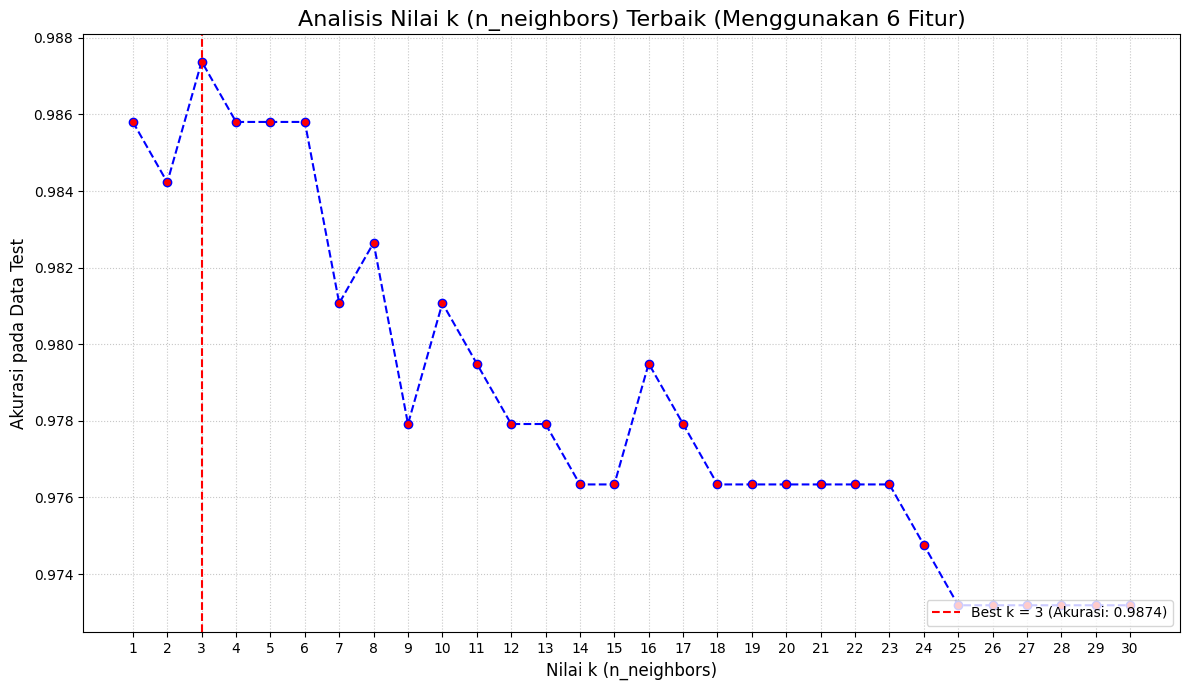

In [ ]:
# Analisis Nilai K Terbaik
k_range = range(1, 31)  # k dari 1 sampai 30
accuracies = []

# Loop untuk setiap nilai k
for k_neighbor in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)

    # Pakai fitur yang terbaik sebelumnya
    knn.fit(X_train_best_features, y_train)

    # Prediksi
    y_pred = knn.predict(X_test_best_features)
    accuracies.append(accuracy_score(y_test, y_pred))

# Cari nilai k terbaik
best_k_neighbor = np.argmax(accuracies) + 1  # +1 karena index (dimana 0 itu default)
best_accuracy_final = max(accuracies)

print(f"\nNilai 'k' (n_neighbors) terbaik ditemukan: {best_k_neighbor}")
print(f"Akurasi final (tertinggi) yang dicapai: {best_accuracy_final:.4f}")

# Membuat plot
plt.figure(figsize=(12, 7))
plt.plot(k_range, accuracies, marker='o', linestyle='dashed', color='b', mfc='r')
plt.title(f'Analisis Nilai k (n_neighbors) Terbaik (Menggunakan {best_k_features_count} Fitur)', fontsize=16)
plt.xlabel('Nilai k (n_neighbors)', fontsize=12)
plt.ylabel('Akurasi pada Data Test', fontsize=12)
plt.xticks(np.arange(1, 31, 1))
plt.axvline(best_k_neighbor, color='red', linestyle='--',
            label=f'Best k = {best_k_neighbor} (Akurasi: {best_accuracy_final:.4f})')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()

# Simpan plot
plt.show()

### Hasil Analisis
- Ambil semua fitur dan gunakan scaling dan latih kNN menggunakan k = 5. Ini menghasilakn akurasi sebesar 97.63%
- Selanjutnya, lakukan seleksi fitur untuk mendapatkan fitur terbaik setelah melakukan testing menggunakan semua kemungkinan fitur dengan hasil 10 fitur dengan 98.58% akurasi dengan fitur sd, Q25, IQR, sp.ent, sfm, meanfun
- Dengan seleksi fitur tersebut, enam fitur tersebut digunakan untuk melatih beberapa model kNN dengan k berbeda untuk melihat hasil akurasi kNN dengan k = 3 mendapatkan akurasi 98.74%